# Assignment 1: Alfonsi, Di Tuccio, Orsini - POS TAGGING


In this assignment, we tested four different neural architectures (BiLSTM/ GRU + Dense Layers) for PoS tagging. One important aspect of this task was the embedding of OOVs words, which we handled by choosing the mean of the word context embeddings when it was possible. Finally, the two best models according to the macro F1 score are the BiLSTM followed by a Dense layer (BiLSTM model) and the two-layer BiLSTM followed by a Dense Layer (ML-BiLSTM model), which both perform with an F1 score equal to 0.79.

This notebook is organized in 14 chapters:
- chapter 1: import libraries and set the random seed;
- chapter 2: download of the dataset folder;
- chapter 3: Train-Validation-Test split + preprocessing of the data;
- chapter 4: some statistics about the data;
- chapter 5: download of the GloVe embedding;
- chapter 6: OOV vocabulary;
- chapter 7: words embedding;
- chapter 8: padding and truncation for X_train, X_val, X_test;
- chapter 9: padding and truncation for y_train, y_val, y_test;
- chapter 10: training of the models;
- chapter 11: evaluation of the model on validation set;
- chapter 12: BiLSTM model performance on test set;
- chapter 13: ML-BiLSTM model performance on test set;
- chapter 14: Bibliography and sitography

## 1. Random Seed

In [1]:
import random
from numpy.random import seed
import numpy as np
import tensorflow as tf
import os
from keras.layers import Embedding, Bidirectional, LSTM, Dense, GRU, Input, Masking, TimeDistributed, Dropout
from keras.models import Model


def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    

# at the end of the notebook, you'll be able to see results using different seeds
random_seed = 10
set_reproducibility(random_seed)

## 2. Download of the dataset folder

In [2]:
import zipfile
import urllib
    
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

data_path = os.path.join(os.getcwd(),"")
data_zip = os.path.join(os.getcwd(),"", "dependency_treebank.zip")

if not os.path.exists(data_path):
    os.makedirs(data_path)

if not os.path.exists(data_zip):
    urllib.request.urlretrieve(url, data_zip)
    print("Successful download")

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall(path=data_path)
    print("Successful extraction")

Successful download
Successful extraction


## 3. Train-Validation-Test split + preprocessing

First we upload all the .dp file names in the folder.

In [3]:
path = "dependency_treebank"
filenames = []
for file in os.listdir("dependency_treebank"):
    if file.endswith(".dp"):
        filenames.append(file)
filenames.sort()

Each document of the dataset contains a column with the words of the sentences, while a second column contains the corresponding POS tags for each word. The dataset contains also a third column, which was ignored during this assignment according to the instructions. Since the first two columns are separated by a tabulation, we kept the correspondence tag for each word and then separated each sentence with the occurrence of a single dot. When each word is extracted by the document, we applied a preprocessing step by reducing all the characters to lowercase, while the POS tags for curly and round brackets are substituted by their punctuation.

In [4]:
def preprocessing(text):
  return text.replace('-LRB-', '(').replace('-RRB-', ')').replace('-LCB-', '{').replace('-RCB-', '}').lower()

Then, we upload the data into a single dataframe with:
- Words (each sentence is stored in the words column; so, we've splitted into sentences instead documents);
- Tags (the tags for the sentence);
- Document (the document where we can find the sentence);
- Split (if the sentence is in the training, val or test set).

In [5]:
import pandas as pd

# we've stored all the sentences in a list
# then the list is converted to a dataframe
# we can't use pd.concat in the loop (O(pd.concat) > O(list.append))
df_list = []

split = {'train':100, 'validation':150}
for i in range(len(filenames)):
  with open(os.path.join(path, filenames[i]), 'r') as f:
    words = []
    tags = []
    for line in f:
      try:
        # we split each line using the tabulation
        tmp = line.split("\t")

        # if the line contains only the word or white space without tags, raise error
        tags.append(preprocessing(tmp[1]))
        words.append(preprocessing(tmp[0]))
        
        # if the word is exactly a point, the sentence is over
        if tmp[0] == ".":
          split_df = 'test'
          if i < split['train']: split_df = 'train'
          elif i < split['validation']: split_df = 'validation'

          # we use a white space between each words and tags
          data = {"Words":' '.join(words), "Tags":' '.join(tags), 'Document':i+1, 'Split':split_df}
          df_list.append(data)
          words = []
          tags = []
      
      # if the line contains only white space
      except:
        pass
df = pd.DataFrame(df_list)
df.head(4)

,Words,Tags,Document,Split
0,"pierre vinken , 61 years old , will join the b...","nnp nnp , cd nns jj , md vb dt nn in dt jj nn ...",1,train
1,"mr. vinken is chairman of elsevier n.v. , the ...","nnp nnp vbz nn in nnp nnp , dt nnp vbg nn .",1,train
2,"rudolph agnew , 55 years old and former chairm...","nnp nnp , cd nns jj cc jj nn in nnp nnp nnp nn...",2,train
3,a form of asbestos once used to make kent ciga...,dt nn in nn rb vbn to vb nnp nn nns vbz vbn dt...,3,train


After that, we split the dataframe into train, test and validation according to the instructions:

In [6]:
train = df[df.Split=='train']
validation = df[df.Split=='validation']
test = df[df.Split=='test']
test.head(4)

,Words,Tags,Document,Split
3192,"intelogic trace inc. , san antonio , texas , s...","nnp nnp nnp , nnp nnp , nnp , vbd prp vbd cd c...",151,test
3193,the move boosts intelogic chairman asher edelm...,dt nn vbz nnp nnp nnp nnp pos nn to cd nn in c...,151,test
3194,mr. ackerman already is seeking to oust mr. ed...,nnp nnp rb vbz vbg to vb nnp nnp in nn in nnp ...,151,test
3195,the action followed by one day an intelogic an...,dt nn vbn in cd nn dt nnp nn in prp md vb dt n...,151,test


## 4. Some Statistics

Before going into deep with the vocabulary and Glove, we saw the distribution of the length of each sentece of the training set, since in a real world scenario it is the only set of data available to train the model. In particular, the histogram below shows that the great majority of the sentences has length between 2 and 50, while only few sentences has length between 50 and 250 (which is the max length).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53cef527c0>]],
      dtype=object)

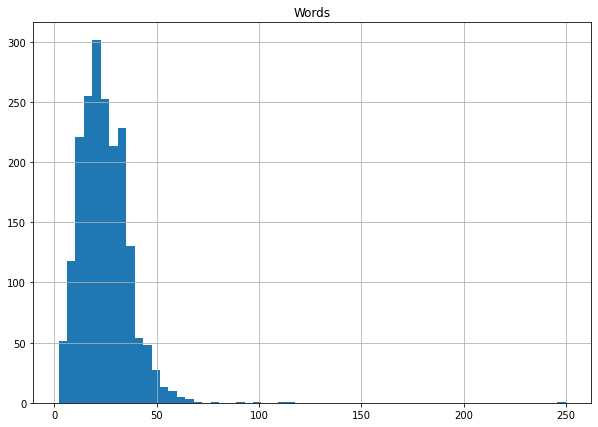

In [7]:
pd.DataFrame(train.Words.apply(lambda x: x.split(" ")).apply(len)).hist(grid=True, bins=60, figsize=(10,7))

Now we compute some statistics: as we can see from the following code, there are 1936 sentences, the mean is about 24.5 words and the max is 250. Since the model requires a fixed input length, it is important to choose it very carefully:

- taking the highest value means doing a lot of padding (and here we have only two sentences with over 100 words;
- taking the mean value means to truncate the half of the sentences.
In the end, we've decided to take the 75% percentile (a compromise between the max and the mean).

In [8]:
max_length = int(pd.DataFrame(train.Words.apply(lambda x: x.split(" ")).apply(len)).quantile(0.75))
print("The 75% quantile is: ", max_length, 'words')
pd.DataFrame(train.Words.apply(lambda x: x.split(" ")).apply(len)).describe()

The 75% quantile is:  31 words


,Words
count,1936.000000
mean,24.459194
std,12.686699
min,2.000000
25%,16.000000
50%,23.000000
75%,31.000000
max,250.000000


Then, we plot the distribution of each tag for each split. Here we can see that special chars appear few times (except for the $ symbol, because there are some currency values). The most common tag is the noun tag.

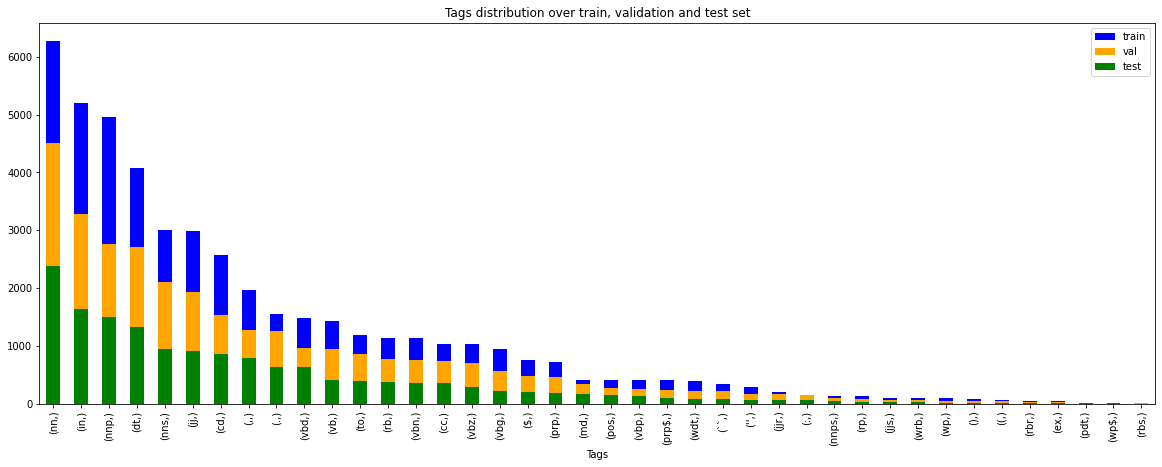

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7))

tags_train = []
tags_val = []
tags_test = []

for i in train.Tags.apply(lambda x: x.split(" ")):
  for j in i:
    tags_train.append(j)

for i in validation.Tags.apply(lambda x: x.split(" ")):
  for j in i:
    tags_val.append(j)

for i in test.Tags.apply(lambda x: x.split(" ")):
  for j in i:
    tags_test.append(j)

pd.DataFrame(tags_train).value_counts().plot(kind='bar', figsize=(20,7), label = 'train', color = 'blue')
pd.DataFrame(tags_val).value_counts().plot(kind='bar', figsize=(20,7), label = 'val', color = 'orange')
pd.DataFrame(tags_test).value_counts().plot(kind='bar', figsize=(20,7), label = 'test', color = 'green')

plt.title('Tags distribution over train, validation and test set')
plt.xlabel('Tags')
plt.legend()

As we can see from the plot, each class has approximately the same distribution for each split, which however has an unbalanced distribution between the classes.


In [10]:
print('Unique tags in train: ', len(set(tags_train)))
print('Unique tags in val: {0}, tags: {1}'.format(len(set(tags_val)), ', '.join([k.upper() for k in set(tags_train) if not k in set(tags_val)])))
print('Unique tags in test: {0}, tags: {1}'.format(len(set(tags_test)), ', '.join([k.upper() for k in set(tags_train) if not k in set(tags_test)])))

Unique tags in train:  45
Unique tags in val: 44, tags: SYM
Unique tags in test: 40, tags: LS, FW, SYM, #, UH


Some classes don't appear in the validation and test split: SYM for both, while #, UH, LS and FW for the test.

## 5. Download of Glove

We've used Wikipedia 2014 + Gigaword 5 Glove (6B tokens, 400k vocab).

In [11]:
url = "https://nlp.stanford.edu/data/glove.6B.zip"

glove_path = os.path.join(os.getcwd(),"Glove")
glove_zip = os.path.join(os.getcwd(),"Glove", "glove.6B.zip")

if not os.path.exists(glove_path):
    os.makedirs(glove_path)

if not os.path.exists(glove_zip):
    urllib.request.urlretrieve(url, glove_zip)
    print("Successful download")

with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(path=glove_path)
    print("Successful extraction")

Successful download
Successful extraction


Here, we've written the function for getting the vocabulary of Glove (given the number of columns, default 50).

In [12]:
def build_glove_vocabulary(columns=50):
  glove_file = os.path.join(os.getcwd(),"Glove", "glove.6B.{0}d.txt".format(columns))
  print ("Loading Glove Model")
  with open(glove_file, encoding="utf8" ) as f:
      lines = f.readlines()
  glove_vocabulary = {}
  for line in lines:
      splits = line.split()
      glove_vocabulary[splits[0]] = np.array([float(val) for val in splits[1:]])
  print ("Done.",len(glove_vocabulary.keys())," words loaded!")
  return glove_vocabulary

## 6. OOV Vocabulary

One of the most important aspect for RNN is the embedding phase. First, we add the OOVs in the Glove vocabulary. In a real scenario, we:

*   Start with a vocabulary V1 (in this assignment, GloVe vocabulary)
*   Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split
*   Add embeddings to the vocabulary, so to obtain vocabulary V2=V1+OOV1
*   Training of the model(s)
*   Compute embeddings for terms OOV2 of the validation split
*   Add embeddings to the vocabulary, so to obtain vocabulary V3=V1+OOV1+OOV2
*   Validation of the model(s)
*   Compute embeddings for terms OOV3 of the test split
*   Add embeddings to the vocabulary, so to obtain vocabulary V4=V1+OOV1+OOV2+OOV3
*   Testing of the final mode<br>

In this case we already have all the documents and so we have simplified a little bit the previous procedure (as explained in the instructions). In particular, we have added the OOVs and calculated embeddings at each step (first train, then val and finally test), but the model is trained and tested after evaluating the OOVs for train, val and test. For the Embedding of the OOVs, we have used the mean of the embedding of the context for each OOV word when it was possible, otherwise we took a random vector. To choose the best embedding dimension of GloVe and the best context size we tested some configuration using the first model (BiLSTM + Dense Layer) on the validation set, the best results were with: 

- 100 dimension (Glove);
- 3 context (actual_word - 3, actual_word + 3)

First, we define a function to build the vocabulary of the dataframe using the tokenizer:

In [13]:
# the words are sep. by a white space, so we simply use split=' '
# X_column --> the name of the columns where the sentences are stored in the dataset (in this case Words)
def build_vocabulary(dataframe, X_column):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', num_words=0, filters='\t\n')
  tokenizer.fit_on_texts(dataframe[X_column])
  return tokenizer.word_index, tokenizer.index_word

Now we need a functoin to find the OOVs of a 'new_vocabulary' wrt 'start_vocabulary':

In [14]:
def find_OOV(start_vocabulary, new_vocabulary):
  return set(new_vocabulary).difference(set(start_vocabulary.keys()))

And a function to build word-word co-occurrence matrix based on word counts:

In [15]:
# from tutorial2 --> calculate the co-occurrence
def co_occurrence_count(df, idx_to_word, word_to_idx, window_size=4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.

    :param df: pre-processed dataset (pandas.DataFrame)
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    :return
      - co_occurrence symmetric matrix of size |V| x |V| (|V| = vocabulary size)
    """
    vocab_size = len(idx_to_word)+1
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for sentence in df.Words.values:
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]

            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index, second_word_index] += 1
    return co_occurrence_matrix

Then we define a function to concatenate the OOVs to the initial vocabulary:

In [16]:
# initial_vocabulary --> the vocabulary where we want to add OOVs
# OOV --> a list of OOVs
# word_idx_vocab_with_OOV --> the vocabulary with word as key with its index (including OOV)
# idx_word_vocab_with_OOV --> the vocabulary with index as key with its word (including OOV)
# co_occurrence --> the co-occurrence-matrix for the given dataframe (the vocabulary are word_idx_vocab_with_OOV and idx_word_vocab_with_OOV)
def mean_concat_OOV_vocabulary(initial_vocabulary, OOV, word_idx_vocab_with_OOV, idx_word_vocab_with_OOV, co_occurrence, columns=50):
  for word in OOV:
    encode = word_idx_vocab_with_OOV[word]
    row_occurence = co_occurrence[encode,:]

    # if the word hasn't any context --> random embedding
    if np.all((row_occurence == 0)):
      embedding_vector = np.random.uniform(low=-0.05, high=0.05, size = columns)
    
    # if the word has some context, we calculate the mean of the embedding (in the initial_vocabulary) of the contexts
    else:
      weights = row_occurence[row_occurence!=0]
      contexts = [idx_word_vocab_with_OOV[c] for c in np.where(row_occurence != 0)[0]]
      
      # if a context word is a OOV unseen, we random it
      embeddings = [initial_vocabulary.get(context_word, np.random.uniform(low=-0.05, high=0.05, size = columns)) for context_word in contexts]
      embedding_vector = np.average(embeddings, weights=weights, axis=0)
    initial_vocabulary[word] = embedding_vector

  return initial_vocabulary

def random_concat_OOV_vocabulary(initial_vocabulary, OOV, columns=50):
  for word in OOV:
    initial_vocabulary[word] = np.random.uniform(low=-0.05, high=0.05, size=columns)
  return initial_vocabulary

To build the vocabulary, we use a sequential order (easy to understand), instead using some functions and having automated code. We remember that we started with a vocabulary that contains the words of the training set that appear also in GloVe, and then we added the OOVs of the training set. Then this process was repeated also for the validation set, where the OOVs are considered wrt the GloVe vocabulary plus the training OOVs; in the same way we operate with the test set, wrt to the GloVe vocabulary plus the OOVs of training and validation set.

In [17]:
# we have found 100 as best dimension for Glove
dimension = 100
context_word = 1

embedding_function = {'mean':mean_concat_OOV_vocabulary, 'random':random_concat_OOV_vocabulary}
current_embedding = 'mean' # use 'mean' for a mean context embedding, 'random' otherwise

# ------------GLOVE------------
# build the glove voc (400k voc)
glove_vocabulary = build_glove_vocabulary(columns=dimension)
print()
print('The vocabulary (tokenizer) starts from 1 with the encode (0 reserved to -PAD-, see later), so the shape for the co-occ is length+1.')
print()


# ------------TRAIN------------

# create the vocabulary for the train set
train_vocabulary_w_i, train_vocabulary_i_w = build_vocabulary(train, "Words")
print("The len of Train Vocabulary is: {0}".format(len(train_vocabulary_w_i)))

# find the OOV for the train wrt the Glove
train_OOV = find_OOV(glove_vocabulary, train_vocabulary_w_i)
print("The OOVs for Train wrt Glove are: {0}".format(len(train_OOV)))

print("The percentage of train OOVs is: {:.0%}".format(round(len(train_OOV)/len(train_vocabulary_w_i),2)))
# build the co_occurrence_matrix for train using a window_size of 3
co_occurrence_train = co_occurrence_count(train, train_vocabulary_i_w, train_vocabulary_w_i, window_size=context_word)
print("The co-occ-matrix for Train has a shape of: {0}".format(co_occurrence_train.shape))

# update the Glove vocabulary with the train's OOV
train_glove_vocabulary = embedding_function[current_embedding](glove_vocabulary, train_OOV, train_vocabulary_w_i, train_vocabulary_i_w, co_occurrence_train, columns=dimension)
print("The new vocabulary size is: {0}".format(len(train_glove_vocabulary)))
print()


# ------------VALIDATION------------

# create the vocabulary for the validation set
validation_vocabulary_w_i, validation_vocabulary_i_w = build_vocabulary(validation, "Words")
print("The len of Validation Vocabulary is: {0}".format(len(validation_vocabulary_w_i)))

# find the OOV for the validation set wrt the Glove + Train's OOV
validation_OOV = find_OOV(train_glove_vocabulary, validation_vocabulary_w_i)
print("The OOVs for Validation wrt Glove + Train's OOV are: {0}".format(len(validation_OOV)))
print("The percentage of validation OOVs is: {:.0%}".format(round(len(validation_OOV)/len(validation_vocabulary_w_i),2)))

# build the co_occurrence_matrix for val using a window_size of 3
co_occurrence_validation = co_occurrence_count(validation, validation_vocabulary_i_w, validation_vocabulary_w_i, window_size=context_word)
print("The co-occ-matrix for Validation has a shape of: {0}".format(co_occurrence_validation.shape))

# update the Glove + Train's OOV vocabulary with the validations's OOV
train_val_glove_vocabulary = embedding_function[current_embedding](train_glove_vocabulary, validation_OOV, validation_vocabulary_w_i, validation_vocabulary_i_w, co_occurrence_validation, columns=dimension)
print("The new vocabulary size is: {0}".format(len(train_val_glove_vocabulary)))
print()


# ------------TEST------------

# create the vocabulary for the test set
test_vocabulary_w_i, test_vocabulary_i_w = build_vocabulary(test, "Words")
print("The len of Test Vocabulary is: {0}".format(len(test_vocabulary_w_i)))

# find the OOV for the test set wrt the Glove + Train's OOV + Val's OOV
test_OOV = find_OOV(train_val_glove_vocabulary, test_vocabulary_w_i)
print("The OOVs for Test wrt Glove + Train's OOV + Val's OOV are: {0}".format(len(test_OOV)))
print("The percentage of test OOVs is: {:.0%}".format(round(len(test_OOV)/len(test_vocabulary_w_i),2)))
# build the co_occurrence_matrix for val using a window_size of 3
co_occurrence_test = co_occurrence_count(test, test_vocabulary_i_w, test_vocabulary_w_i, window_size=context_word)
print("The co-occ-matrix for Test has a shape of: {0}".format(co_occurrence_test.shape))

# update the Glove + Train's OOV vocabulary with the validations's OOV
train_val_test_glove_vocabulary = embedding_function[current_embedding](train_val_glove_vocabulary, test_OOV, test_vocabulary_w_i, test_vocabulary_i_w, co_occurrence_test, columns=dimension)
print("The new vocabulary size is: {0}".format(len(train_val_test_glove_vocabulary)))

Loading Glove Model
Done. 400000  words loaded!

The vocabulary (tokenizer) starts from 1 with the encode (0 reserved to -PAD-, see later), so the shape for the co-occ is length+1.

The len of Train Vocabulary is: 7402
The OOVs for Train wrt Glove are: 355
The percentage of train OOVs is: 5%
The co-occ-matrix for Train has a shape of: (7403, 7403)
The new vocabulary size is: 400355

The len of Validation Vocabulary is: 5420
The OOVs for Validation wrt Glove + Train's OOV are: 189
The percentage of validation OOVs is: 3%
The co-occ-matrix for Validation has a shape of: (5421, 5421)
The new vocabulary size is: 400544

The len of Test Vocabulary is: 3407
The OOVs for Test wrt Glove + Train's OOV + Val's OOV are: 128
The percentage of test OOVs is: 4%
The co-occ-matrix for Test has a shape of: (3408, 3408)
The new vocabulary size is: 400672


In [18]:
# some OOVs of the test set (in particular acronyms and numbers)
print(test_OOV)

{'more-advanced', 'crookery', 'computer-services', '566.54', '630.9', '811.9', 'protein-1', 'weapons-modernization', '170,262', 'inter-tel', 'blood-cell', '5,699', '494.50', 'asset-valuation', '87-store', 'acquisition-minded', 'intelogic', 'constitutional-law', '36-store', '608,413', 'ex-dividend', '120-a-share', 'cash-and-stock', 'waymar', 'pro-iranian', 'disputada', 'passenger-car', 'bankruptcy-law', '292.32', '26,956', 'reupke', '387.8', 'prior-year', '2,050-passenger', 'blue-chips', 'yet-to-be-formed', 'unicorp', '377.60', '237-seat', 'tete-a-tete', '263.07', '319.75', '220.45', 'nofzinger', '50\\/50', 'g.m.b', 'several-year', 'conn.based', 'high-rolling', '226,570,380', 'near-limit', 'above-market', 'headcount-control', '5.2180', '434.4', 'sewing-machine', 'lentjes', '158,666', 'waertsilae', 'cost-control', 'seven-yen', 'per-share', 'bread-and-butter', '372.14', 'copper-rich', '154,240,000', '618.1', '361.8', '734.9', 'corn-buying', '11-month-old', '45-a-share', '967,809', 'yoshih

Then, we do the same with random assignment for the OOVs. As we can see, the vocabulary has 400672 elements as before, with random embedding for the OOVs.

In [19]:
def build_split(dataset, vocabulary, column_name="Words", window_size=3, dimension=50, current_embedding=random_concat_OOV_vocabulary):
  vocabulary_w_i, vocabulary_i_w = build_vocabulary(dataset, column_name)
  OOV = find_OOV(vocabulary, vocabulary_w_i)
  return current_embedding(vocabulary, OOV, columns=dimension)

random_vocabulary = glove_vocabulary.copy()
random_vocabulary = build_split(train, random_vocabulary, dimension=dimension)
random_vocabulary = build_split(validation, random_vocabulary, dimension=dimension)
random_vocabulary = build_split(test, random_vocabulary, dimension=dimension)
print(len(random_vocabulary))

400672


## 7. Embedding

Now we have a vocabulary without OOVs of train, val and test. So, we need to build the Embedding Matrix. For simplicity, we build an embedding matrix with only the words of training, validation and test set, without considering the other words of GloVe that don't appear in this task. 

In [20]:
def build_embedding_matrix(voc_embedding, vocabulary, columns=50):
    rows = len(vocabulary)
    embedding_matrix = np.zeros((rows+1, columns))
    for word, index in vocabulary.items():
      embedding_vector = voc_embedding.get(word)
      embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [21]:
# ------------TRAIN-VAL-TEST------------
# build embedding matrix using the Glove Voc + OOVs of train+val+test (computed previously)
train_test_val_vocabulary_w_i, train_test_val_vocabulary_i_w = build_vocabulary(df, "Words")
embedding_matrix = build_embedding_matrix(train_val_test_glove_vocabulary, train_test_val_vocabulary_w_i, columns=dimension)
embedding_matrix.shape

(10946, 100)

The Embedding Matrix (train+val+test) is: (without the first row, -PAD- with only 0s)

In [22]:
pd.DataFrame(embedding_matrix, index=list(train_test_val_vocabulary_i_w.values()).append('-PAD-'))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000
1,-0.107670,0.11053,0.59812,-0.54361,0.673960,0.106630,0.038867,0.354810,0.063510,-0.094189,...,0.349510,-0.722600,0.375490,0.444100,-0.99059,0.61214,-0.35111,-0.831550,0.45293,0.082577
2,-0.038194,-0.24487,0.72812,-0.39961,0.083172,0.043953,-0.391410,0.334400,-0.575450,0.087459,...,0.016215,-0.017099,-0.389840,0.874240,-0.72569,-0.51058,-0.52028,-0.145900,0.82780,0.270620
3,-0.339790,0.20941,0.46348,-0.64792,-0.383770,0.038034,0.171270,0.159780,0.466190,-0.019169,...,-0.063351,-0.674120,-0.068895,0.536040,-0.87773,0.31802,-0.39242,-0.233940,0.47298,-0.028803
4,-0.152900,-0.24279,0.89837,0.16996,0.535160,0.487840,-0.588260,-0.179820,-1.358100,0.425410,...,0.187120,-0.018488,-0.267570,0.727000,-0.59363,-0.34839,-0.56094,-0.591000,1.00390,0.206640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10941,-0.674900,1.24910,-0.20589,0.30409,0.956890,-0.070804,-0.739220,0.132180,0.625330,0.068480,...,0.267230,-0.344820,-0.247260,0.273270,-0.10251,-0.15400,-0.61960,-0.358480,0.97729,0.231860
10942,0.353960,-1.42890,0.74630,-0.20343,-0.580970,0.712080,-0.156970,0.330540,-0.120700,0.820530,...,-1.162800,-0.129670,-0.301680,0.058908,0.51902,0.19820,-0.64066,-0.999100,0.48595,-0.586540
10943,0.168650,1.19110,0.17452,-0.27608,-0.265470,-0.307260,0.745120,0.485540,-0.078094,-0.079655,...,-0.547290,0.382220,-0.207870,0.157960,0.59973,0.01948,0.48689,-0.325070,0.36698,-0.179930
10944,-0.324430,0.84650,-0.56920,-0.37743,1.048800,-1.067600,-0.334530,0.049853,0.732600,0.238410,...,0.086618,0.429520,-0.434800,0.211480,-0.11567,-0.18205,-0.87171,-0.028931,1.41150,0.280300


As we can see the first embedding is a vector with only 0s, which we use to encode each zero of the pad.

Here, we can see the position of the embedding for 3 OOVs in the train ('telephone-information', 'vinken').

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



Words are:  ['telephone-information', 'vinken']


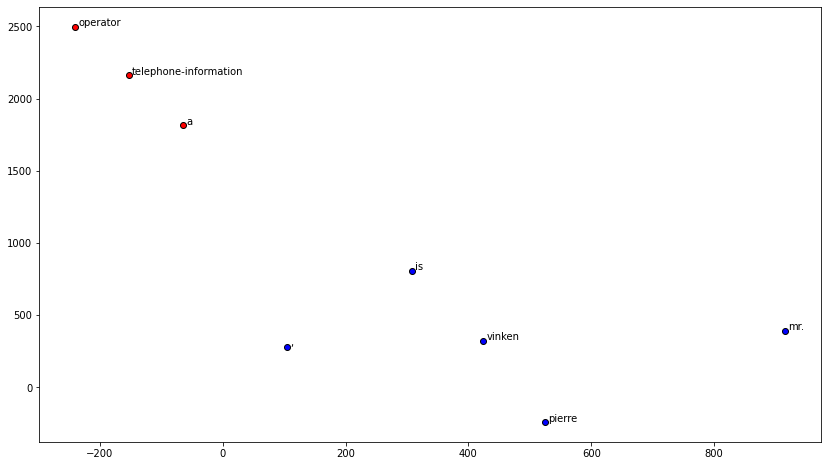

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(14, 8))

strings = ['telephone-information', 'vinken']
contexts = []
sep = []
for string in strings:
  index = train_vocabulary_w_i[string]
  current = [train_vocabulary_i_w[c] for c in np.where(co_occurrence_train[index] != 0)[0]]
  contexts = contexts.copy() + current.copy()
  contexts.append(string)
  sep.append(len(current))

embeddings = [train_val_test_glove_vocabulary[context_word] for context_word in contexts]

word_vectors = embeddings

tsne = TSNE(n_components=2, random_state=1, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = contexts

prev = 0
color = ['red', 'blue', 'yellow']
count = 0
for i in sep:
  plt.scatter(T[prev:prev+i+1, 0], T[prev:prev+i+1, 1], c=color[count], edgecolors='k')
  prev = prev+i+1
  count += 1
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+5, y+5), xytext=(0, 0), textcoords='offset points')
print()
print("Words are: ", strings)
plt.show()

As before, we do the same for with the random embeddings.

In [24]:
random_embedding_matrix = build_embedding_matrix(random_vocabulary, train_test_val_vocabulary_w_i, columns=dimension)
random_embedding_matrix.shape

(10946, 100)

## 8. Padding and Truncation for X_train, X_val, X_test

Here, we encode the sentences using the Tokenizer() and then we apply zero-padding for the sentences with a length less than the 75 quantile, while we truncate sentences with lentgh grater than the 75 percentile.

In [25]:
# TEXT2SEQUENCE --> PADDING

# as before, we can use a single tokenizer (stored in a file), but the split are 
# always equal and we wanted a notebook easy to unserstans, step by step
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', num_words=0, filters='\t\n')
word_tokenizer.fit_on_texts(df.Words)


# ---------TRAIN---------
# encode of the sentences
X_train = word_tokenizer.texts_to_sequences(train.Words)
print('Sentence: \t\t', train.Words.iloc[0])
print('Encode for that row:    ', X_train[0])
# apply the padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = max_length, truncating='post')
print('Padding for that row:   ', [k for k in X_train[0]])
print()


# ---------VALIDATION---------
X_val = word_tokenizer.texts_to_sequences(validation.Words)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding = 'post', maxlen = max_length, truncating='post')


# ---------TEST---------
X_test = word_tokenizer.texts_to_sequences(test.Words)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen = max_length, truncating='post')

print('Shape for X_train: ', X_train.shape)
print('Shape for X_val:   ', X_val.shape)
print('Shape for X_test:  ', X_test.shape)

Sentence: 		 pierre vinken , 61 years old , will join the board as a nonexecutive director nov. 29 .
Encode for that row:     [5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3]
Padding for that row:    [5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Shape for X_train:  (1936, 31)
Shape for X_val:    (1256, 31)
Shape for X_test:   (636, 31)


## 9. Tags: y_train, y_val, y_test

Then, we do the same previous process for the labels y_train, y_val, y_test. Since the output of the Dense Layer is in the one-hot encoder form, we need to transform the tags. To do this we use the keras function to_categorical, which transform each tag in a one-hot encoder vector. We encoded also the PAD tag: since the Keras Dense Layer doesn't support masking, our models need also to learn the mapping of zeros of the padding to their class 'PAD'.

In [26]:
# as before, we haven't use functions for an understandable notebook

# find the unique tags in the whole document using Tokenizer()
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', num_words=0, filters='\t\n')
tag_tokenizer.fit_on_texts(df.Tags)
n_tags = len(tag_tokenizer.word_index)+1 # the tokenizer starts from 1 for the encoding (0 reserved to the -PAD-)
print('The unique tags are: {0}, plus -PAD-'.format(n_tags-1))
print('Tags are: ', tag_tokenizer.word_index)
print()


# ---------TRAIN---------

# encode the train tags using the previous Tokenizer()
y_train = tag_tokenizer.texts_to_sequences(train.Tags)
print('Sentence: \t\t\t', train.Words.iloc[0])
print('The tags for that row are: \t', train.Tags.iloc[0])
print('The encode for the tags are: \t', y_train[0])
print('The inverse of the sequence is: ', tag_tokenizer.sequences_to_texts(y_train)[0].upper())

# add padding
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding = 'post', maxlen = max_length, truncating='post')
print('The encode + pad for that row are: ', y_train[0])
print('The inverse of the pad sequence is: ', tag_tokenizer.sequences_to_texts(y_train)[0])

# one hot encoder for each tag in the sequence

y_train = tf.keras.utils.to_categorical(y_train, num_classes = n_tags)
print('Shape for that row: ', y_train[0].shape)
print(y_train[0].shape)
print()
print()


# ---------VALIDATION---------
y_val = tag_tokenizer.texts_to_sequences(validation.Tags)
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val, padding = 'post', maxlen = max_length, truncating='post')
y_val = tf.keras.utils.to_categorical(y_val, num_classes = n_tags)


# ---------TEST---------
y_test = tag_tokenizer.texts_to_sequences(test.Tags)
y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, padding = 'post', maxlen = max_length, truncating='post')
y_test = tf.keras.utils.to_categorical(y_test, num_classes = n_tags)

print('Shape for y_train: ', y_train.shape)
print('Shape for y_val:   ', y_val.shape)
print('Shape for y_test:  ', y_test.shape)

The unique tags are: 45, plus -PAD-
Tags are:  {'nn': 1, 'in': 2, 'nnp': 3, 'dt': 4, 'nns': 5, 'jj': 6, ',': 7, '.': 8, 'cd': 9, 'vbd': 10, 'rb': 11, 'vb': 12, 'cc': 13, 'to': 14, 'vbn': 15, 'vbz': 16, 'prp': 17, 'vbg': 18, 'vbp': 19, 'md': 20, 'pos': 21, 'prp$': 22, '$': 23, '``': 24, "''": 25, ':': 26, 'wdt': 27, 'jjr': 28, 'nnps': 29, 'wp': 30, 'rp': 31, 'jjs': 32, 'wrb': 33, 'rbr': 34, ')': 35, '(': 36, 'ex': 37, 'rbs': 38, 'pdt': 39, '#': 40, 'wp$': 41, 'ls': 42, 'fw': 43, 'uh': 44, 'sym': 45}

Sentence: 			 pierre vinken , 61 years old , will join the board as a nonexecutive director nov. 29 .
The tags for that row are: 	 nnp nnp , cd nns jj , md vb dt nn in dt jj nn nnp cd .
The encode for the tags are: 	 [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]
The inverse of the sequence is:  NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD .
The encode + pad for that row are:  [ 3  3  7  9  5  6  7 20 12  4  1  2  4  6  1  3  9  8  0  0  0  0  0  0
  0  0  0  0  0  0  0]
T

## 10. The models

For this task we used the four models suggested in the instructions:
- the BiLSTM model, which has a bidirectional LSTM followed by a Dense Layer;
- the BiGRU model, which has a bidierectional GRU followed by a Dense Layer;
- BiDense model, where two Dense Layers follow a bidirectional LSTM
- ML-BiLSTM, which uses two Bidirectional LSTM followed by a Dense Layer.<br>

Each Dense Layer used is actually a Time Distributed Dense layer, which is used as 'classification head' with a softmax activation function (except for the Bi_Dense model, which uses a Time Distributed Layer as hidden layer). 

For each architecture, after the input layer there is the embedding layer that replaces each word: in particular, each zero of padding is replaced by a vector of only zeros taken from the embedding matrix. As we said before, Keras Dense Layer doesn't support masking, so each model has also to learn the mapping from 0 to the class '-PAD-'.

The tuning of the hyperparameters was performed on the validation set. For each model, we used a fixed batch size equal to 32 and n. of epochs equal to 30. To avoid overfitting, we used dropout to the input conmnections within the LSTM/GRU layer and also the L2 recurrent regularization.




In [27]:
batch_size = 32
n_epochs = 30
verbose = 0

y_pred_val = {}
histories = {}
models = {}

set_reproducibility(random_seed)

**BiLSTM Model**


---


The first model is a Bidirectional LSTM followed by a Time Distributed Layer that acts as 'classification head'. We found that the best number of units for the Bidirectional LSTM layer is 64, and we also notice that by using a number of units greater than 100 the performance on the validation set doesn't improve. Here the input dropout value is 0.2.


In [28]:
input = Input(shape=max_length, name = "Input_Layer")
embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=dimension, weights=[embedding_matrix], input_length=max_length, trainable=False, name = 'Embedding_Layer')(input)
bi_LSTM = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2, recurrent_regularizer = 'l2', name = 'LSTM', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=random_seed), bias_initializer=tf.keras.initializers.zeros, recurrent_initializer=tf.keras.initializers.zeros), name='BiLSTM_Layer')(embed_layer)
dense_layer = TimeDistributed(Dense(n_tags, activation='softmax', name = 'DenseLayer', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=random_seed), bias_initializer=tf.keras.initializers.zeros), name='TimeDistributed_Layer')(bi_LSTM)
model_Bi_LSTM = Model(input, dense_layer, name='BiLSTM')
models['BiLSTM']=model_Bi_LSTM
model_Bi_LSTM.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 31)]              0         
                                                                 
 Embedding_Layer (Embedding)  (None, 31, 100)          1094600   
                                                                 
 BiLSTM_Layer (Bidirectional  (None, 31, 128)          84480     
 )                                                               
                                                                 
 TimeDistributed_Layer (Time  (None, 31, 46)           5934      
 Distributed)                                                    
                                                                 
Total params: 1,185,014
Trainable params: 90,414
Non-trainable params: 1,094,600
_________________________________________________________________


Then, we build the same model using the random embeddings. 

In [29]:
input = Input(shape=max_length, name = "Input_Layer")
embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=dimension, weights=[random_embedding_matrix], input_length=max_length, trainable=False, name = 'Embedding_Layer')(input)
bi_LSTM = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2, recurrent_regularizer = 'l2', name = 'LSTM', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=random_seed), bias_initializer=tf.keras.initializers.zeros, recurrent_initializer=tf.keras.initializers.zeros), name='BiLSTM_Layer')(embed_layer)
dense_layer = TimeDistributed(Dense(n_tags, activation='softmax', name = 'DenseLayer', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=random_seed), bias_initializer=tf.keras.initializers.zeros), name='TimeDistributed_Layer')(bi_LSTM)
model_random_Bi_LSTM = Model(input, dense_layer, name='Random_BiLSTM')
models['Random_BiLSTM']=model_random_Bi_LSTM
model_random_Bi_LSTM.summary()

Model: "Random_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 31)]              0         
                                                                 
 Embedding_Layer (Embedding)  (None, 31, 100)          1094600   
                                                                 
 BiLSTM_Layer (Bidirectional  (None, 31, 128)          84480     
 )                                                               
                                                                 
 TimeDistributed_Layer (Time  (None, 31, 46)           5934      
 Distributed)                                                    
                                                                 
Total params: 1,185,014
Trainable params: 90,414
Non-trainable params: 1,094,600
_________________________________________________________________


**BiGRU Model**


---


The second model is a Bidirectional GRU followed by a Time Distributed Layer that acts as 'classification head'. We found that the best number of units for the Bidirectional GRU layer is 64 (the same of the BiLSTM model), and we also notice that, like in the previous model,  by using a number of units greater than 100 the performance on the validation set doesn't improve. Here the input dropout value is 0.1.

In [30]:
input = Input(shape=max_length, name = "Input_Layer")
embed_layer = Embedding(input_dim=embedding_matrix.shape[0], name = 'Embedding_Layer', output_dim=dimension, weights=[embedding_matrix], input_length=max_length, trainable=False)(input)
bi_LSTM = Bidirectional(GRU(64, return_sequences=True, dropout = 0.1, recurrent_regularizer = 'l2', name = 'GRU'), name='BiGRU_Layer')(embed_layer)
dense_layer = TimeDistributed(Dense(n_tags, activation='softmax', name = 'DenseLayer'), name='TimeDistributed_Layer')(bi_LSTM)
model_Bi_GRU = Model(input, dense_layer, name='BiGRU')
models['BiGRU']=model_Bi_GRU
model_Bi_GRU.summary()

Model: "BiGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 31)]              0         
                                                                 
 Embedding_Layer (Embedding)  (None, 31, 100)          1094600   
                                                                 
 BiGRU_Layer (Bidirectional)  (None, 31, 128)          63744     
                                                                 
 TimeDistributed_Layer (Time  (None, 31, 46)           5934      
 Distributed)                                                    
                                                                 
Total params: 1,164,278
Trainable params: 69,678
Non-trainable params: 1,094,600
_________________________________________________________________


**BiDense Model**


---


The third model is a Bidirectional LSTM followed by two Time Distributed Layers.

Here we havea Bidirectional LSTM layer with 30 units, which is followed by two Time Distributed Dense Layers. The last one is the 'classification head', while the penultimate one is identical to the latter but uses ReLu as activation function.  Here the input dropout value for the Bidirectional LSTM is 0.1.

In [31]:
input = Input(shape=max_length, name = "Input_Layer")
embed_layer = Embedding(input_dim=embedding_matrix.shape[0], name = 'Embedding_Layer', output_dim=dimension, weights=[embedding_matrix], input_length=max_length, trainable=False)(input)
bi_LSTM = Bidirectional(LSTM(30, return_sequences=True, dropout = 0.1, recurrent_regularizer = 'l2'), name='BiLSTM_Layer')(embed_layer) # When return_sequences is set to False, Dense is applied to the last time step only
dense_layer = TimeDistributed(Dense(n_tags, activation='ReLU'), name='TimeDistributed1_Layer')(bi_LSTM)
dense_layer = TimeDistributed(Dense(n_tags, activation='softmax'), name='TimeDistributed2_Layer')(dense_layer)
model_Bi_Dense = Model(input, dense_layer, name='BiDense')
models['BiDense']=model_Bi_Dense
model_Bi_Dense.summary()

Model: "BiDense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 31)]              0         
                                                                 
 Embedding_Layer (Embedding)  (None, 31, 100)          1094600   
                                                                 
 BiLSTM_Layer (Bidirectional  (None, 31, 60)           31440     
 )                                                               
                                                                 
 TimeDistributed1_Layer (Tim  (None, 31, 46)           2806      
 eDistributed)                                                   
                                                                 
 TimeDistributed2_Layer (Tim  (None, 31, 46)           2162      
 eDistributed)                                                   
                                                           

**ML_BiLSTM Model**


---


The last Model uses two Bidirectional LSTM layers, with 64 and 32 units respectively, followed by the usual 'classification head'. It's interesting to see that here we applied input dropout (with value equal to 0.1) to only the first Bi_LSTM layer:


In [32]:
input = Input(shape=max_length, name = "Input_Layer")
embed_layer = Embedding(input_dim=embedding_matrix.shape[0], name = 'Embedding_Layer', output_dim=dimension, weights=[embedding_matrix], input_length=max_length, trainable=False)(input)
bi_LSTM = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.1, recurrent_regularizer = 'l2'), name='BiLSTM1_Layer')(embed_layer) # When return_sequences is set to False, Dense is applied to the last time step only
bi_LSTM = Bidirectional(LSTM(32, return_sequences=True, recurrent_regularizer = 'l2'), name='BiLSTM2_Layer')(bi_LSTM) # When return_sequences is set to False, Dense is applied to the last time step only
dense_layer = TimeDistributed(Dense(n_tags, activation='softmax'), name='TimeDistributed_Layer')(bi_LSTM)
model_Double_BiLSTM = Model(input, dense_layer, name='ML_BiLSTM')
models['ML_BiLSTM']=model_Double_BiLSTM
model_Double_BiLSTM.summary()

Model: "ML_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 31)]              0         
                                                                 
 Embedding_Layer (Embedding)  (None, 31, 100)          1094600   
                                                                 
 BiLSTM1_Layer (Bidirectiona  (None, 31, 128)          84480     
 l)                                                              
                                                                 
 BiLSTM2_Layer (Bidirectiona  (None, 31, 64)           41216     
 l)                                                              
                                                                 
 TimeDistributed_Layer (Time  (None, 31, 46)           2990      
 Distributed)                                                    
                                                         

Here we trained each model with a decreasing learning rate (0.1 --> 0.01 --> 0.001) over the epochs. 

In [ ]:
from keras.callbacks import ModelCheckpoint

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint_path = "training_weights"
checkpoint_dir = os.path.dirname(checkpoint_path)

def scheduler(epoch, lr):

    if epoch < n_epochs*0.2:
        return 0.1
   
    elif epoch < n_epochs*0.8 and epoch >= n_epochs*0.2:
        return 0.01
    
    else:
        return 0.001

cbk = tf.keras.callbacks.LearningRateScheduler(scheduler)


for i in list(models.keys()):
  print('************************* Training for:', models[i].name, '*************************')
  #mcp_save = ModelCheckpoint(checkpoint_path+'/{0}_{1}.hdf5'.format(models[i].name, random_seed), save_best_only=True, monitor='val_acc', mode='min')
  adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
  models[i].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
  histories[i]=models[i].fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, callbacks = [callback, cbk], validation_data = (X_val, y_val), verbose = verbose)
  print('\n')


************************* Training for: BiLSTM *************************
40/40 [==============================] - 1s 3ms/step


************************* Training for: Random_BiLSTM *************************
40/40 [==============================] - 1s 3ms/step


************************* Training for: BiGRU *************************
40/40 [==============================] - 1s 3ms/step


************************* Training for: BiDense *************************
40/40 [==============================] - 1s 3ms/step


************************* Training for: ML_BiLSTM *************************
40/40 [==============================] - 1s 5ms/step




Below we can see the accuracy of each model on both training and validation set over the epochs.

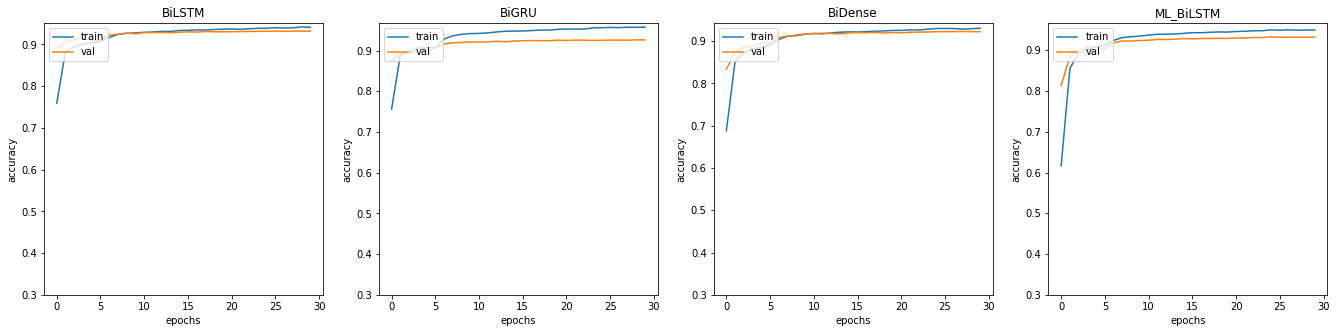

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (23,5))

count = 0
for j in ['BiLSTM', 'BiGRU', 'BiDense', 'ML_BiLSTM']: 
  plt.subplot(1, 4, count+1)
  count += 1
  plt.plot(histories[j].history['acc'])
  plt.plot(histories[j].history['val_acc'])
  plt.xticks(np.arange(0, n_epochs+2, 5))
  plt.yticks(np.arange(0.3, 1, 0.1))
  plt.title(models[j].name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper left')
plt.show()

These plots shows that the accuracy on the validation set is always close the one the training set: it seems that BiGRU overfits more than the other models, but if we print the accuracy of the last epoch (where it seems to be the highest difference between the two accuracies):

In [ ]:
print('Accuracy on the training set for BiGRU:', round(histories['BiGRU'].history['acc'][-1],2))
print('Accuracy on the validation set for BiGRU:', round(histories['BiGRU'].history['val_acc'][-1],2))

Accuracy on the training set for BiGRU: 0.96
Accuracy on the validation set for BiGRU: 0.93


we can see that there is a difference of only the 3% between the two.

## 11. F1 Score for the models on the validation set

In [46]:
# here there are some print functions (for macro F1 score, classification report, etc)
# you can skip this part and see directly the results 
from numpy import argmax
from sklearn.metrics import classification_report
from statistics import mean

punctuation = [",", ".", "''", ":", "(", ")", "``", "#", "{", "}", '$']

# we build a single list where appending all the results
# ex: if val.shape=100 and max_length=10 (max n. of words in a sentence), the total length is 100*10=1000
# y --> the list of lists of one-hot-encoding
# max_length --> max n. of words in a sentence
def unique_list(y, max_length):
  unique_list = []
  for i in range(len(y)):
    for j in range(max_length):

      # first we convert each one-hot-encoding in the integer encoding 
      argmax = y[i][j].argmax()

      # not pad
      if argmax > 0:
        # we take the word using the encode integer
        tag = tag_tokenizer.index_word[argmax]
        unique_list.append(tag.upper())

      # padding
      else:
        unique_list.append("-PAD-")
  return unique_list


# print the macro F1 score without punctuation
# print_report --> True if you want to show accuracy and F1 for each class
# pad --> True if you want to print the F1 score with the class -PAD-
# printF1 --> True if you want to show the macro F1
def f1_score(y_true, y_pred, name, print_report = False, pad = False, printF1=True, printClasses=False):
  if print_report: print("Report for ", name)
  report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
  f1 = []
  to_remove = ["macro avg", "accuracy","weighted avg"]
  total = 0
  count_1 = 0
  count_2 = 0
  count_3 = 0
  if not pad: to_remove.append('-PAD-')
  for c in list(report.keys()):
    if c in punctuation or c in to_remove: continue
    total += 1
    f1.append(report[c]["f1-score"])
    if print_report:
      print("Class: {0}\tF1: {1:.3f}\tSupport: {2}\tPrecision: {3}\t\tRecall: {4}".format(c, report[c]["f1-score"], report[c]['support'], round(report[c]["precision"],2), round(report[c]["recall"],2)))
      if report[c]["f1-score"] >= 0.8:
        count_1 += 1
      elif report[c]["f1-score"] >= 0.5 and report[c]["f1-score"] < 0.8 :
        count_2 += 1
      else: count_3 += 1
  if printF1:
    print("The F1-macro for {0} is: {1:.3f}".format(name, mean(f1)))
  if printClasses:
    print("The percentage of classes with F1 score higher than 0.8 is {:.2%}".format(round(count_1/total, 2)))
    print("The percentage of classes with F1 score between 0.5 and 0.8 is {:.2%} ".format(round(count_2/total,2)))
    print("The percentage of classes with F1 score lower than 0.5 is {:.2%} ".format(round(count_3/total,2)))
  if print_report: print()
  return mean(f1), report


# print the F1 score for the class -PAD-
def f1_pad(y_true, y_pred, name):
   report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
   for k in list(report.keys()):
     if k == '-PAD-':
       print('The -PAD- F1 score for {0} is: {1}'.format(name, round(report[k]['f1-score'],3)))


# print the report (F1, score) for each class for the OOVs
def OOV_report(y_test, y_pred, X_test, name, OOV):
  count_true_OOV = 0 # count the number of OOV correctly guessed
  total_OOV = 0 # it's not sufficient use the voc OOV length, because a OOV can appear many times
  true_OOV = []
  pred_OOV = []
  for i in range(len(X_test)):
    if X_test[i] in OOV:
      if y_test[i] == y_pred[i]:
        count_true_OOV += 1
      pred_OOV.append(y_pred[i])
      true_OOV.append(y_test[i])
      total_OOV += 1
  f1_score(true_OOV, pred_OOV, name=name, print_report=True)
  return count_true_OOV/total_OOV*100


# print the F1 diff between the left model and the right model (for each class, it prints F1_left - F1_right)
def diff_f1(left, right, right_name='Random Embedding', string='context and random embedding'):
  print('F1 score difference between {0}:'.format(string))
  to_remove = ["macro avg", "weighted avg", "accuracy"]
  for i in list(left.keys()):
    if i in punctuation or i in to_remove: continue
    diff = None
    try:
      diff = left[i]['f1-score']-right[i]['f1-score']
      diff = round(diff, 2)
      if diff >= 0: print('Class: {0}\tF1 diff: \033[92m+{1}\033[0m'.format(i, abs(diff)))
      else: print('Class: {0}\tF1 diff: \033[91m-{1}\033[0m'.format(i, abs(diff)))
    except: # if a class isn't in the right model
      diff = left[i]['f1-score']
      print('Class: {0}\tF1 diff: {1} (Not in the {2})'.format(i, round(abs(diff),2), right_name))

In [34]:
!git clone https://github.com/DitucSpa/POS_Tagging_NLP

Cloning into 'POS_Tagging_NLP'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 36 (delta 19), reused 26 (delta 18), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [35]:
checkpoint_path = "POS_Tagging_NLP/training_weights"

Now, we upload the model weights for each model. We train the model for seed 1, 10 and 6666. In addition, we save the model with seed equal to 10 for showing the F1 score for each tag and the test of the models. 

In [45]:
concat_val = unique_list(y_val, max_length)
for i in list(models.keys()):
  val_mean = []
  for seed_loop in [1, 10, 66666]:
    models[i].load_weights(checkpoint_path+'/{0}_{1}.hdf5'.format(models[i].name, seed_loop)) # load weights
    adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
    models[i].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
    models[i].evaluate(X_val, y_val, batch_size=32, verbose=0)
    y_pred=models[i].predict(X_val, verbose=0)
    if seed_loop==10: y_pred_val[i]=y_pred 
    tmp, _ = f1_score(concat_val, unique_list(y_pred, max_length), name = models[i].name+' without -PAD-', print_report=False, printF1=False)
    val_mean.append(tmp)
  print('Model: {0}, mean val F1: {1}'.format(models[i].name, round(mean(val_mean),2)))

Model: BiLSTM, mean val F1: 0.75
Model: Random_BiLSTM, mean val F1: 0.74
Model: BiGRU, mean val F1: 0.73
Model: BiDense, mean val F1: 0.7
Model: ML_BiLSTM, mean val F1: 0.74


Let's see the F1 score on the validation set with and without the padding for the random and context embedding with seed=10. In the following box, we show with green values the F1 scores for the classes where the context embedding has a higher/equal values than random.

In [37]:
concat_val = unique_list(y_val, max_length)
diff_f1(f1_score(concat_val, unique_list(y_pred_val['BiLSTM'], max_length), name = models['BiLSTM'].name+' without -PAD-', print_report = False)[1], f1_score(concat_val, unique_list(y_pred_val['Random_BiLSTM'], max_length), name = models['Random_BiLSTM'].name+' without -PAD-', print_report = False)[1] )

The F1-macro for BiLSTM without -PAD- is: 0.763
The F1-macro for Random_BiLSTM without -PAD- is: 0.736
F1 score difference between context and random embedding:
Class: -PAD-	F1 diff: +0.0
Class: CC	F1 diff: -0.01
Class: CD	F1 diff: -0.01
Class: DT	F1 diff: +0.0
Class: EX	F1 diff: +0.0
Class: FW	F1 diff: +0.0
Class: IN	F1 diff: +0.0
Class: JJ	F1 diff: +0.0
Class: JJR	F1 diff: +0.01
Class: JJS	F1 diff: -0.07
Class: LS	F1 diff: +0.0
Class: MD	F1 diff: +0.0
Class: NN	F1 diff: +0.0
Class: NNP	F1 diff: -0.01
Class: NNPS	F1 diff: +0.04
Class: NNS	F1 diff: -0.01
Class: PDT	F1 diff: +0.0
Class: POS	F1 diff: -0.01
Class: PRP	F1 diff: +0.0
Class: PRP$	F1 diff: +0.0
Class: RB	F1 diff: +0.0
Class: RBR	F1 diff: -0.02
Class: RBS	F1 diff: +0.35
Class: RP	F1 diff: -0.04
Class: TO	F1 diff: +0.0
Class: UH	F1 diff: +0.67
Class: VB	F1 diff: -0.01
Class: VBD	F1 diff: +0.0
Class: VBG	F1 diff: +0.0
Class: VBN	F1 diff: +0.01
Class: VBP	F1 diff: +0.03
Class: VBZ	F1 diff: +0.0
Class: WDT	F1 diff: +0.04
Class: WP

First of all, the macro F1 score is higher for the context embedding of 3%. More specifically, we can see that only 10 classes have a higher value for the F1 score for random embedding, and we can also notice that these differences are very little, since the highest one has an absolute value of 0.7. Regarding the classes with an higher F1 score for the context embedding, only for RBS and UH there is an big improvement, while for the others the values are more or less the same.
Then, we can conclude that the context embedding has a big impact only for the RBS and UH classes (with an increase of 0.35 and 0.67 respectively), which however reflects an improvement for the F1 score of the context embedding of 3%. Since this embedding has the highest F1 score, we picked this. 

In [38]:
for k in ['BiLSTM', 'BiGRU', 'BiDense', 'ML_BiLSTM']:
  f1_pad(concat_val, unique_list(y_pred_val[k], max_length), models[k].name)
  f1 = f1_score(concat_val, unique_list(y_pred_val[k], max_length), name = models[k].name+' without -PAD-', print_report=False)
  print()

The -PAD- F1 score for BiLSTM is: 1.0
The F1-macro for BiLSTM without -PAD- is: 0.763

The -PAD- F1 score for BiGRU is: 1.0
The F1-macro for BiGRU without -PAD- is: 0.722

The -PAD- F1 score for BiDense is: 1.0
The F1-macro for BiDense without -PAD- is: 0.707

The -PAD- F1 score for ML_BiLSTM is: 1.0
The F1-macro for ML_BiLSTM without -PAD- is: 0.745



As we can see, each model has correctly leant (with F1 score = 1) the mapping from the zeros of the padding to the class -PAD-. According to the macro F1 score on the validation set, the two best models are the Bi_LSTM and the ML-BiLSTM, which we are now going to evaluate on the test set, by using the weights saved with seed=10.

## 12. Test of BiLSTM model 
Now we test the BiLSTM model on the test set and prints some results:

In [39]:
models['BiLSTM'].load_weights(checkpoint_path+'/BiLSTM_10.hdf5')
y_pred_bi_lstm = models['BiLSTM'].predict(X_test, verbose=verbose)
y_pred_bi_lstm = unique_list(y_pred_bi_lstm, max_length)
y_test_bi_lstm = unique_list(y_test, max_length)
_,_ = f1_score(y_test_bi_lstm, y_pred_bi_lstm, name='BiLSTM without -PAD-', print_report=True, pad=False, printClasses=True)

Report for  BiLSTM without -PAD-
Class: CC	F1: 0.994	Support: 336	Precision: 0.99		Recall: 1.0
Class: CD	F1: 0.978	Support: 767	Precision: 0.99		Recall: 0.97
Class: DT	F1: 0.987	Support: 1269	Precision: 0.99		Recall: 0.98
Class: EX	F1: 0.909	Support: 5	Precision: 0.83		Recall: 1.0
Class: IN	F1: 0.963	Support: 1538	Precision: 0.95		Recall: 0.97
Class: JJ	F1: 0.806	Support: 869	Precision: 0.78		Recall: 0.83
Class: JJR	F1: 0.759	Support: 57	Precision: 0.8		Recall: 0.72
Class: JJS	F1: 0.807	Support: 31	Precision: 0.88		Recall: 0.74
Class: LS	F1: 0.000	Support: 0	Precision: 0.0		Recall: 0.0
Class: MD	F1: 0.982	Support: 160	Precision: 0.96		Recall: 1.0
Class: NN	F1: 0.872	Support: 2217	Precision: 0.86		Recall: 0.88
Class: NNP	F1: 0.853	Support: 1414	Precision: 0.89		Recall: 0.82
Class: NNPS	F1: 0.182	Support: 39	Precision: 0.31		Recall: 0.13
Class: NNS	F1: 0.907	Support: 881	Precision: 0.89		Recall: 0.93
Class: PDT	F1: 0.000	Support: 4	Precision: 0.0		Recall: 0.0
Class: POS	F1: 0.959	Support

The performance on the test set in 0.79, which is higher than the one on the validation set, 0.76. To explore more in detail the reasons of this behaviour,let's compare the performance of the model (BiLSTM) for each class, on the validation and test splits. The green results are better F1 scores for the validation set, while the red results for the test split.

In [40]:
diff_f1(f1_score(concat_val, unique_list(y_pred_val['BiLSTM'], max_length), name = models['BiLSTM'].name+' without -PAD- for VAL', print_report = False)[1], f1_score(y_test_bi_lstm, y_pred_bi_lstm, name = models['BiLSTM'].name+' without -PAD- for TEST', print_report = False)[1], right_name='Test', string='validation and test')

The F1-macro for BiLSTM without -PAD- for VAL is: 0.763
The F1-macro for BiLSTM without -PAD- for TEST is: 0.790
F1 score difference between validation and test:
Class: -PAD-	F1 diff: +0.0
Class: CC	F1 diff: -0.01
Class: CD	F1 diff: -0.02
Class: DT	F1 diff: +0.0
Class: EX	F1 diff: +0.04
Class: FW	F1 diff: 0.0 (Not in the Test)
Class: IN	F1 diff: +0.0
Class: JJ	F1 diff: -0.01
Class: JJR	F1 diff: +0.0
Class: JJS	F1 diff: -0.06
Class: LS	F1 diff: +0.0
Class: MD	F1 diff: +0.01
Class: NN	F1 diff: -0.01
Class: NNP	F1 diff: -0.02
Class: NNPS	F1 diff: +0.04
Class: NNS	F1 diff: -0.01
Class: PDT	F1 diff: +0.11
Class: POS	F1 diff: +0.0
Class: PRP	F1 diff: +0.0
Class: PRP$	F1 diff: +0.0
Class: RB	F1 diff: +0.01
Class: RBR	F1 diff: +0.08
Class: RBS	F1 diff: +0.18
Class: RP	F1 diff: -0.13
Class: TO	F1 diff: +0.0
Class: UH	F1 diff: 0.67 (Not in the Test)
Class: VB	F1 diff: -0.05
Class: VBD	F1 diff: -0.06
Class: VBG	F1 diff: -0.01
Class: VBN	F1 diff: -0.02
Class: VBP	F1 diff: +0.01
Class: VBZ	F1 diff:

As we can see, half of the classes are better for the validation set, the other half for the test split, even if the differences are very little. What affects the final F1 score is that in the test set there are two classes that don't appear (UH and FW, as shown in the chapter '4. Some Statistics'). Besides, their F1 scores are very low: these two values decrease the macro F1 score of the validation split wrt the test set. Indeed, if we print the F1 score for Test and Val without the classes UH and FW we obtain the same macro F1 score.

In [41]:
punctuation = [",", ".", "''", ":", "(", ")", "``", "#", "{", "}", '$', 'UH', 'FW']
_ = f1_score(concat_val, unique_list(y_pred_val['BiLSTM'], max_length), name = models['BiLSTM'].name+' without -PAD- for VAL', print_report = False)[0]
_ = f1_score(y_test_bi_lstm, y_pred_bi_lstm, name = models['BiLSTM'].name+' without -PAD- for TEST', print_report = False)[0]
punctuation = [",", ".", "''", ":", "(", ")", "``", "#", "{", "}", '$']

The F1-macro for BiLSTM without -PAD- for VAL is: 0.789
The F1-macro for BiLSTM without -PAD- for TEST is: 0.790


<br>

## 13. Test of the ML-BiLSTM
Now we test the BiLSTM model on the test set and prints some results:

In [42]:
models['ML_BiLSTM'].load_weights(checkpoint_path+'/ML_BiLSTM_10.hdf5')
y_pred_ML_bi_lstm = unique_list(models['ML_BiLSTM'].predict(X_test, verbose=verbose), max_length)
y_test_ML_bi_lstm = unique_list(y_test, max_length)
_,_ = f1_score(y_test_ML_bi_lstm, y_pred_ML_bi_lstm, name='ML-BiLSTM without -PAD-', print_report=True, pad=False, printClasses=True)

Report for  ML-BiLSTM without -PAD-
Class: CC	F1: 0.994	Support: 336	Precision: 0.99		Recall: 1.0
Class: CD	F1: 0.974	Support: 767	Precision: 0.98		Recall: 0.97
Class: DT	F1: 0.987	Support: 1269	Precision: 0.99		Recall: 0.98
Class: EX	F1: 0.909	Support: 5	Precision: 0.83		Recall: 1.0
Class: IN	F1: 0.960	Support: 1538	Precision: 0.95		Recall: 0.97
Class: JJ	F1: 0.803	Support: 869	Precision: 0.78		Recall: 0.83
Class: JJR	F1: 0.835	Support: 57	Precision: 0.83		Recall: 0.84
Class: JJS	F1: 0.759	Support: 31	Precision: 0.81		Recall: 0.71
Class: MD	F1: 0.981	Support: 160	Precision: 0.97		Recall: 0.99
Class: NN	F1: 0.873	Support: 2217	Precision: 0.87		Recall: 0.88
Class: NNP	F1: 0.866	Support: 1414	Precision: 0.89		Recall: 0.84
Class: NNPS	F1: 0.089	Support: 39	Precision: 0.33		Recall: 0.05
Class: NNS	F1: 0.904	Support: 881	Precision: 0.88		Recall: 0.93
Class: PDT	F1: 0.000	Support: 4	Precision: 0.0		Recall: 0.0
Class: POS	F1: 0.931	Support: 143	Precision: 0.96		Recall: 0.9
Class: PRP	F1: 0.99

Here the performance on the test set is 0.79, which is higher than the one on the validation set, 0.75. As we have done for the previous model, let's compare the performance of the model (ML-BiLSTM) on the validation and test splits. The green results are better F1 scores for the validation set, while the red results for the test split.

In [43]:
diff_f1(f1_score(concat_val, unique_list(y_pred_val['ML_BiLSTM'], max_length), name = models['ML_BiLSTM'].name+' without -PAD- for VAL', print_report = False)[1], f1_score(y_test_bi_lstm, y_pred_bi_lstm, name = models['ML_BiLSTM'].name+' without -PAD- for TEST', print_report = False)[1], right_name='Test', string='validation and test')

The F1-macro for ML_BiLSTM without -PAD- for VAL is: 0.745
The F1-macro for ML_BiLSTM without -PAD- for TEST is: 0.790
F1 score difference between validation and test:
Class: -PAD-	F1 diff: +0.0
Class: CC	F1 diff: +0.0
Class: CD	F1 diff: -0.02
Class: DT	F1 diff: +0.0
Class: EX	F1 diff: +0.04
Class: FW	F1 diff: 0.0 (Not in the Test)
Class: IN	F1 diff: +0.0
Class: JJ	F1 diff: -0.01
Class: JJR	F1 diff: +0.03
Class: JJS	F1 diff: -0.05
Class: MD	F1 diff: +0.0
Class: NN	F1 diff: -0.02
Class: NNP	F1 diff: -0.01
Class: NNPS	F1 diff: -0.12
Class: NNS	F1 diff: -0.01
Class: PDT	F1 diff: +0.0
Class: POS	F1 diff: +0.01
Class: PRP	F1 diff: +0.0
Class: PRP$	F1 diff: +0.0
Class: RB	F1 diff: -0.02
Class: RBR	F1 diff: -0.01
Class: RBS	F1 diff: +0.17
Class: RP	F1 diff: -0.1
Class: TO	F1 diff: +0.0
Class: UH	F1 diff: 0.0 (Not in the Test)
Class: VB	F1 diff: -0.18
Class: VBD	F1 diff: -0.07
Class: VBG	F1 diff: -0.04
Class: VBN	F1 diff: -0.02
Class: VBP	F1 diff: -0.05
Class: VBZ	F1 diff: +0.01
Class: WDT	F1 

As we can see, the macro F1 score of the validation is influenced by the classes UH and FW, as the previous model. Note that, for ML-BiLSTM, the F1 score for UH is worse than the UH's F1 score for BiLSTM.

In [44]:
punctuation = [",", ".", "''", ":", "(", ")", "``", "#", "{", "}", '$', 'UH', 'FW']
_ = f1_score(concat_val, unique_list(y_pred_val['ML_BiLSTM'], max_length), name = models['ML_BiLSTM'].name+' without -PAD- for VAL', print_report = False)[0]
_ = f1_score(y_test_ML_bi_lstm, y_pred_ML_bi_lstm, name = models['ML_BiLSTM'].name+' without -PAD- for TEST', print_report = False)[0]
punctuation = [",", ".", "''", ":", "(", ")", "``", "#", "{", "}", '$']

The F1-macro for ML_BiLSTM without -PAD- for VAL is: 0.791
The F1-macro for ML_BiLSTM without -PAD- for TEST is: 0.792


# 14. Bibliography and sitography

- [Word Embedding and GloVe, Towards Data Science](https://medium.com/@jonathan-hui/nlp-word-embedding-glove-5e7f523999f6);
- [Handling OOV, Towards Data Science](https://medium.com/analytics-vidhya/handling-out-of-vocabulary-words-in-natural-language-processing-based-on-context-4bbba16214d5);
- [LSTM and GloVe, Towards Data Science](https://medium.com/towards-data-science/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7);
- [Padding and Masking, Towards Data Science](https://medium.com/@shailaja21/preprocessing-sequence-data-in-keras-padding-masking-techniques-aa087fe7319c);
- [Multi-Class Text Classification with LSTM, Towards Data Science](https://medium.com/towards-data-science/multi-class-text-classification-with-lstm-1590bee1bd17);
- [Units in LSTM, Coding Notes](https://tung2389.github.io/coding-note/unitslstm);
- [Difference between LSTM recurrent dropout and dropout, StackOverflow](https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout);
- [GloVe Official Website](https://nlp.stanford.edu/projects/glove/);
- [Scikit-Learn Official Website](https://scikit-learn.org/stable/);
- [Keras Official Website](https://keras.io).


#GitHub Repository
You can find the PDF, the notebook and the model weights on:
https://github.com/DitucSpa/POS_Tagging_NLP